In [1]:
import sys
import importlib
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import glob
from src.scNODE.optim.running import constructscNODEModel, scNODETrainWithPreTrain, scNODEPredict

In [2]:
adata = sc.read_h5ad('../data/thymocyte.h5ad')

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
X = adata.X
if hasattr(X, "A"):  
    X = X.A
X = X.astype(np.float32)

In [5]:
n_cells, n_genes = X.shape
n_tps = 10
indices = np.arange(n_cells)
bins = np.array_split(indices, n_tps)
cell_tps = np.zeros(n_cells, dtype=int)
for t, idx in enumerate(bins):
    cell_tps[idx] = t

print("Cells per pseudo-timepoint:")
for t in range(n_tps):
    print(f"  t={t}: {np.sum(cell_tps == t)} cells")

Cells per pseudo-timepoint:
  t=0: 1975 cells
  t=1: 1975 cells
  t=2: 1975 cells
  t=3: 1975 cells
  t=4: 1974 cells
  t=5: 1974 cells
  t=6: 1974 cells
  t=7: 1974 cells
  t=8: 1974 cells
  t=9: 1974 cells


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
traj_data = []
max_cells_per_tp = 300
for t in range(n_tps):
    idx_t = np.where(cell_tps == t)[0]
    if len(idx_t) > max_cells_per_tp:
        idx_t = np.random.choice(idx_t, max_cells_per_tp, replace=False)

    X_t = X[idx_t, :]
    traj_data.append(torch.tensor(X_t, dtype=torch.float32, device=device))

tps = torch.tensor(list(range(n_tps)), dtype=torch.float32)
train_data = traj_data
train_tps  = tps


In [8]:
train_data = traj_data
train_tps = tps.clone()

In [9]:
latent_dim = 50
enc_latent_list = [512, 128]
dec_latent_list = [128, 512]
drift_latent_size = [128]

In [10]:
latent_ode_model = constructscNODEModel(
    n_genes,
    latent_dim=latent_dim,
    enc_latent_list=enc_latent_list,
    dec_latent_list=dec_latent_list,
    drift_latent_size=drift_latent_size,
    latent_enc_act="relu",
    latent_dec_act="relu",
    drift_act="relu",
    ode_method="euler",
)

latent_ode_model = latent_ode_model.to(device)

In [11]:
pretrain_iters = 200
pretrain_lr = 1e-3
latent_coeff = 1.0      
epochs = 10
iters = 100
batch_size = 64
lr = 1e-3

In [13]:
latent_ode_model, loss_list, recon_obs, first_latent_dist, latent_seq = scNODETrainWithPreTrain(
    train_data,
    train_tps,
    latent_ode_model,
    latent_coeff=latent_coeff,
    epochs=epochs,
    iters=iters,
    batch_size=batch_size,
    lr=lr,
    pretrain_iters=pretrain_iters,
    pretrain_lr=pretrain_lr,
)

[ Epoch 1 ]:   0%|          | 0/100 [00:00<?, ?it/s]/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
[ Epoch 10 ]: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s, Loss=503.830 | OT=503.219, Dynamic_Reg=0.611]


In [14]:
torch.save(latent_ode_model, "../models/scnode/latent_ode_model_thy.pth")

In [12]:
latent_ode_model = torch.load("../models/scnode/latent_ode_model_thy.pth", weights_only=False)
latent_ode_model.eval()

scNODE(
  (latent_encoder): LinearVAENet(
    (net): Sequential(
      (0): Linear(in_features=2000, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=50, bias=True)
      (5): ReLU()
    )
    (mu_layer): Linear(in_features=50, out_features=50, bias=True)
    (var_layer): Linear(in_features=50, out_features=50, bias=True)
  )
  (diffeq_decoder): ODE(
    (net): LinearNet(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=50, bias=True)
        (3): ReLU()
      )
    )
  )
  (obs_decoder): LinearNet(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=2000, bias=True)
     

In [13]:
X_torch = torch.tensor(X, dtype=torch.float32, device=device)

latent_ode_model.eval()
with torch.no_grad():
    mu, std = latent_ode_model.latent_encoder(X_torch) 

X_latent = mu.detach().cpu().numpy()  

In [32]:
n_cells = 200                
first_tp_data = train_data[0]    
tps = train_tps                

with torch.no_grad():
    z_0, Z, X_syn = latent_ode_model.predict(
        first_tp_data,
        tps,
        n_cells=n_cells,
    )   


/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [33]:
Z = Z.reshape(-1, latent_dim)
X_syn = X_syn.reshape(-1, n_genes)

In [ ]:
N_target = 200
N_total = X_syn.shape[0]

idx = np.linspace(0, N_total - 1, N_target).astype(int)

Z = Z[idx]
X_syn = X_syn[idx].cpu().numpy() 

In [35]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [36]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [37]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


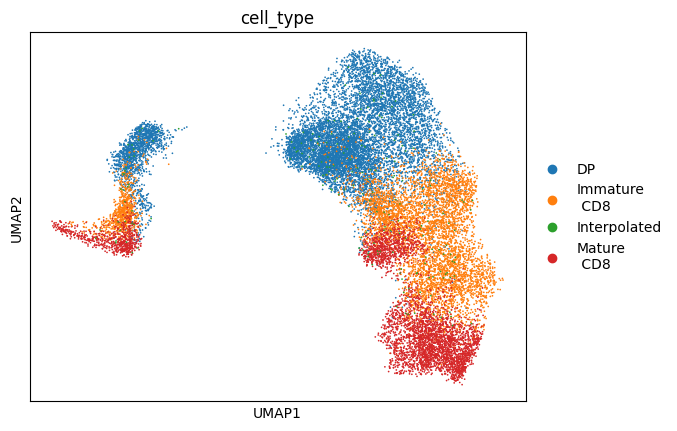

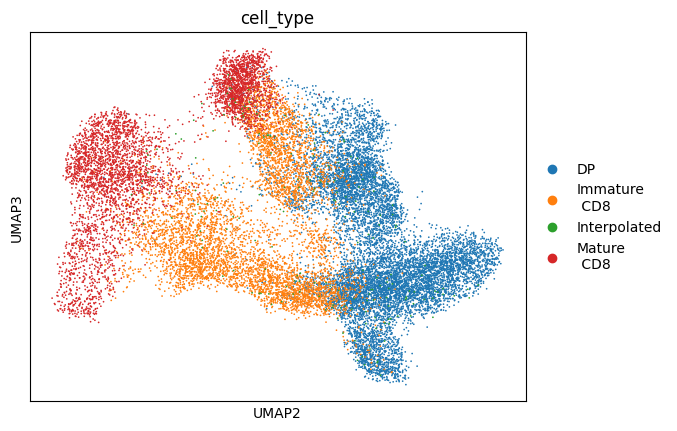

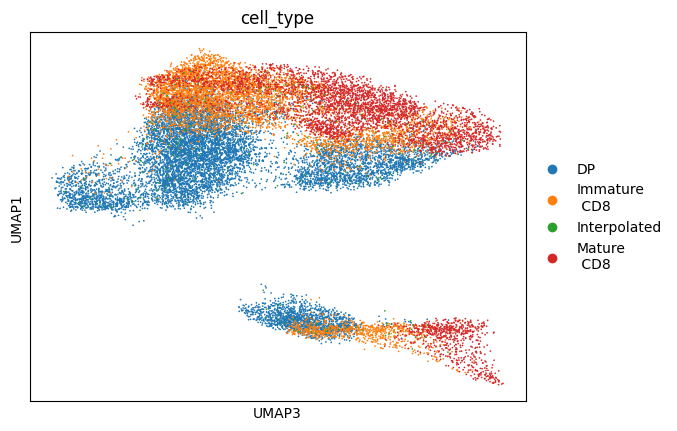

In [38]:
plot_umap(combined_adata, 'cell_type')

In [22]:
adata.var_names = adata.var_names.str.upper()
adata.var.index = adata.var_names
adata.var['gene_short_name'] = adata.var.index

Available dp markers: ['RAG1', 'RAG2', 'DNTT']
Available immature cd4 markers: ['TRAC', 'TRBC1', 'CD69']
Available mature cd4 markers: ['IL7R', 'CCR7', 'LST1']


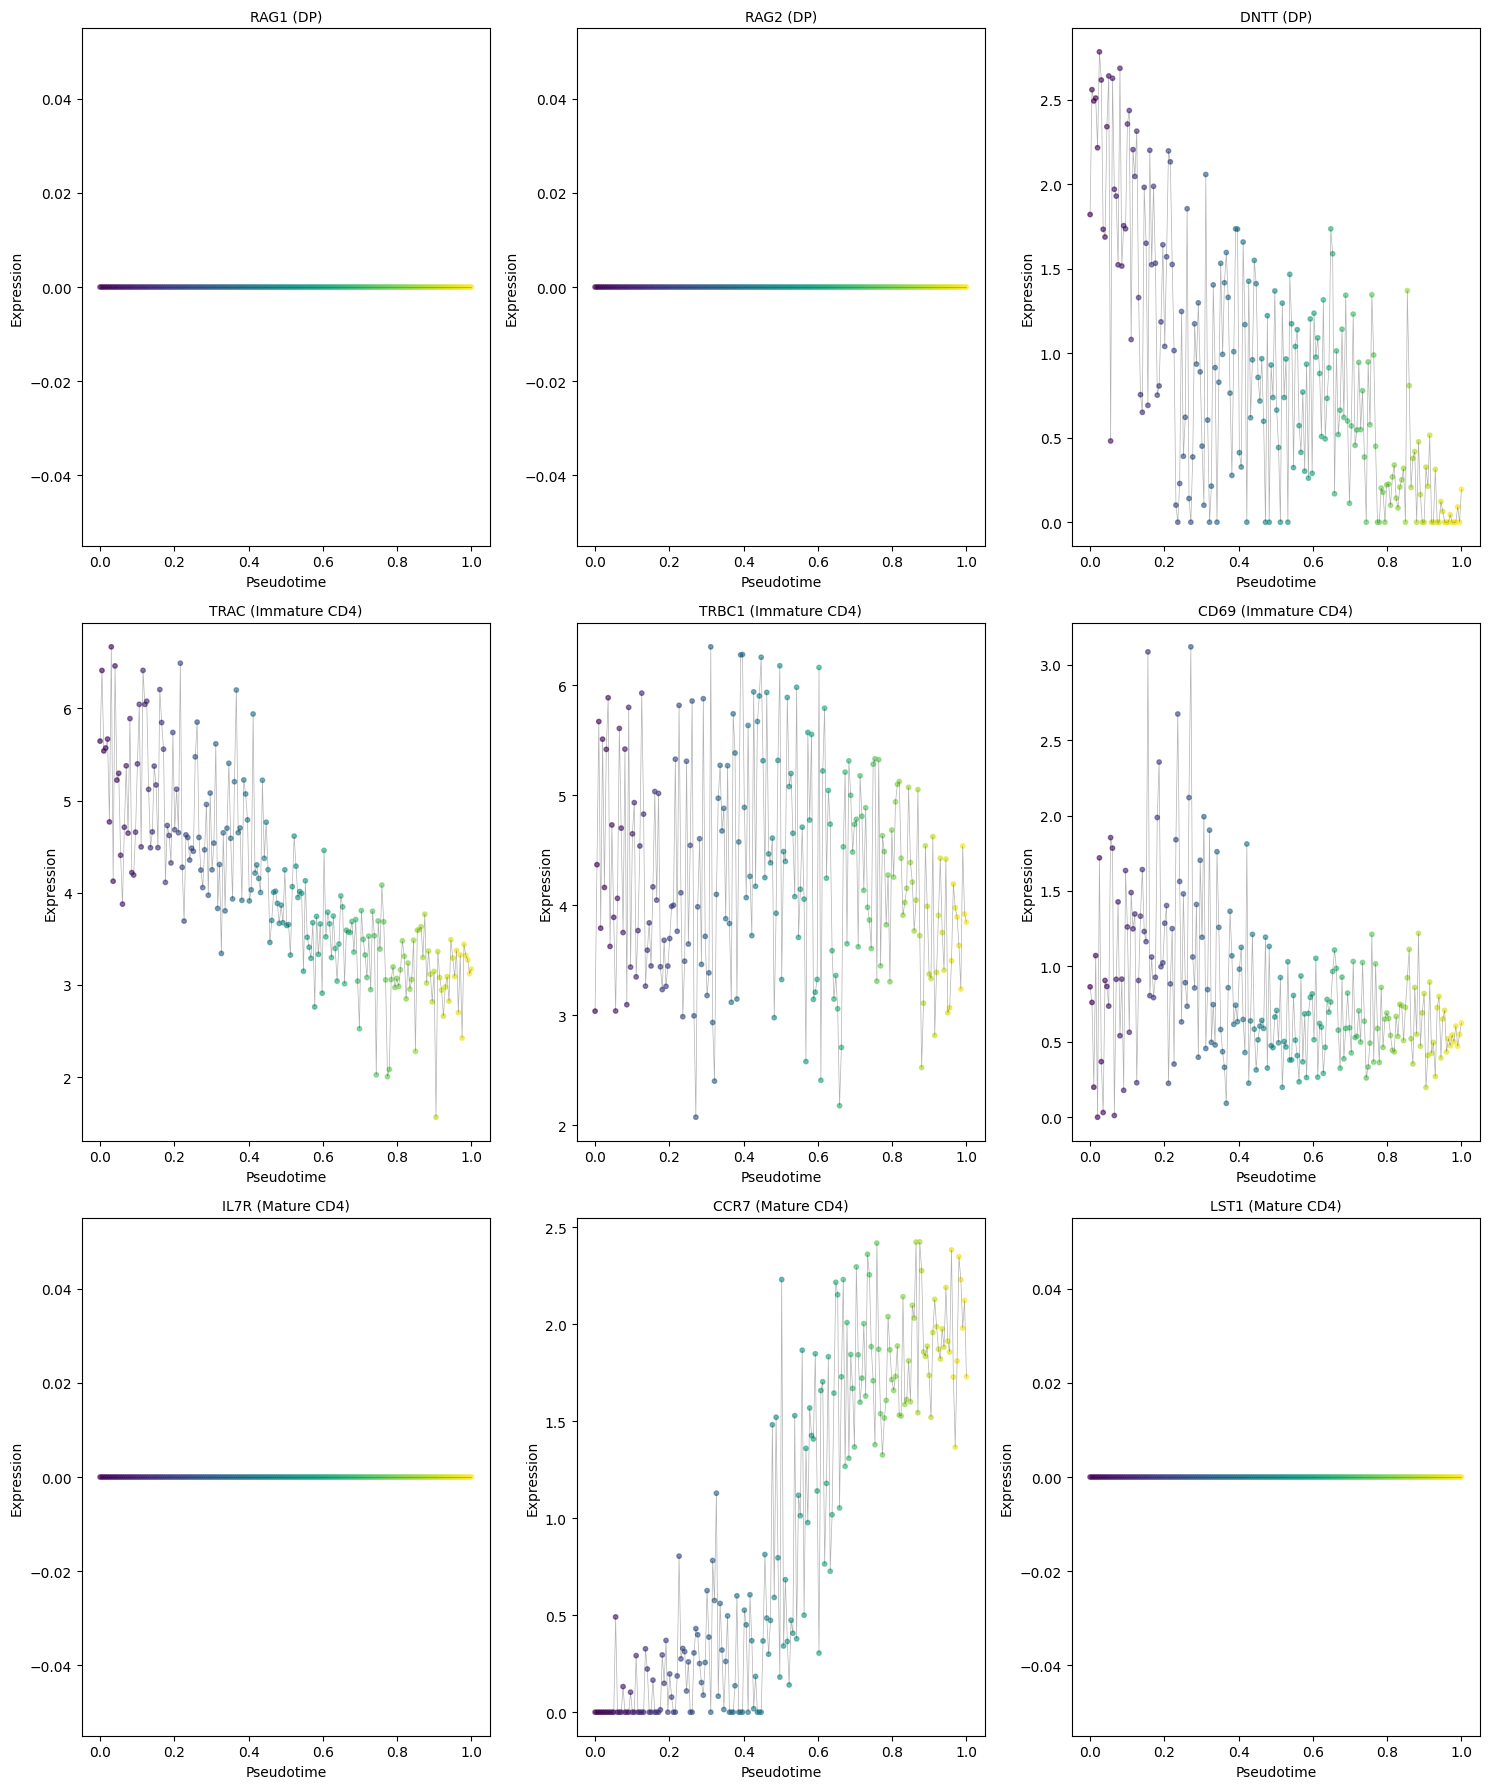

In [39]:
dp_markers = ['RAG1', 'RAG2', 'DNTT']
immature_cd4_markers = ['TRAC', 'TRBC1', 'CD69']
mature_cd4_markers = ['IL7R', 'CCR7', 'LST1']
gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_dp = [g for g in dp_markers if g in gene_names]
available_immature_cd4 = [g for g in immature_cd4_markers if g in gene_names]
available_mature_cd4 = [g for g in mature_cd4_markers if g in gene_names]

print(f"Available dp markers: {available_dp}")
print(f"Available immature cd4 markers: {available_immature_cd4}")
print(f"Available mature cd4 markers: {available_mature_cd4}")

if available_dp or available_immature_cd4 or available_mature_cd4:
    n_markers = len(available_dp) + len(available_immature_cd4) + len(available_mature_cd4)
    n_cols = 3
    n_rows = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,len(X_syn))
    
    plot_idx = 0
    for gene in available_dp:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (DP)', fontsize=10)
        plot_idx += 1
    
    for gene in available_immature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Immature CD4)', fontsize=10)
        plot_idx += 1

    for gene in available_mature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mature CD4)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No common markers found in the dataset")

In [40]:
Z = Z.cpu().numpy()

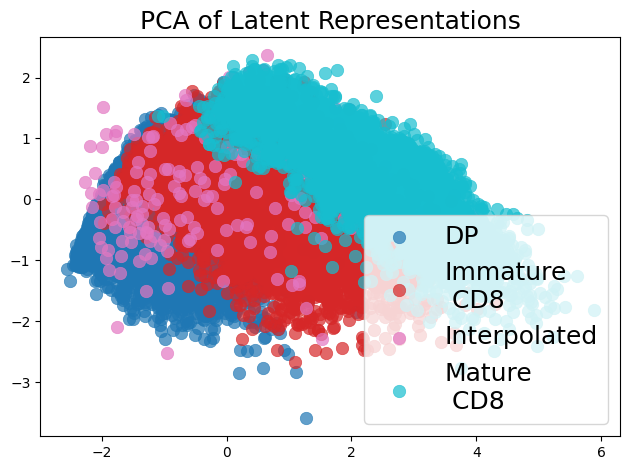

In [41]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}

for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

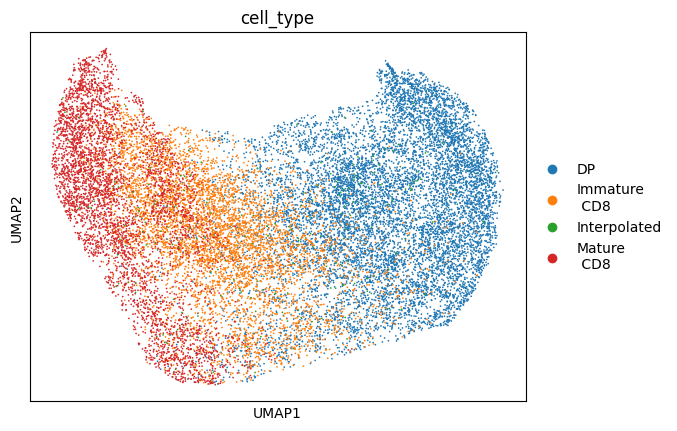

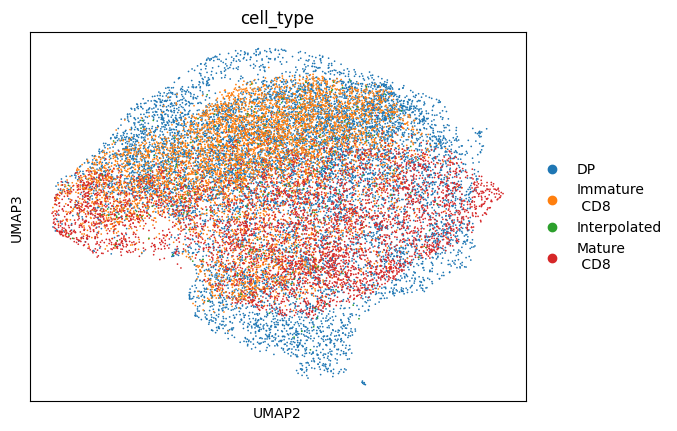

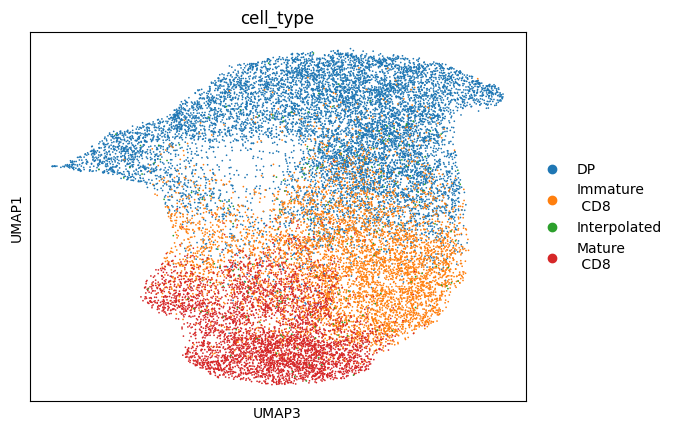

In [42]:
adata_latent_syn = anndata.AnnData(Z)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [43]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, len(X_syn)),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.15436569850011986, 'delta_t_median': 0.14171123478430603, 'delta_t_max': 0.46709491020471006, 'dist_mean': 26.078376016616822, 'dist_median': 26.232820510864258, 'dist_max': 31.80705451965332}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.233728,0.233728,27.836794
1,0.005025,0.223409,0.218384,28.352278
2,0.010050,0.239360,0.229310,27.305006
3,0.015075,0.282084,0.267008,27.184734
4,0.020101,0.223409,0.203308,28.291008


In [44]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 26.078376016616822, 'dist_median': 26.232820510864258, 'dist_max': 31.80705451965332, 'smooth_mean_abs_delta': 1.1680454177473059, 'smooth_max_abs_delta': 5.1987152099609375}


In [49]:
marker_sets = {
    "DP": ['RAG1', 'RAG2', 'DNTT'],
    "Immature CD4": ['TRAC', 'TRBC1', 'CD69'],
    "Mature CD4": ['IL7R', 'CCR7', 'LST1']
}

gene2idx = {g: i for i, g in enumerate(gene_names)}

filtered_marker_sets = {}
for group, genes in marker_sets.items():
    keep = []
    for g in genes:
        if g not in gene2idx:
            continue
        idx = gene2idx[g]
        expr = X_syn[:, idx]

        if np.nanmin(expr) == np.nanmax(expr):
            continue

        keep.append(g)

    if keep:
        filtered_marker_sets[group] = keep

expected_directions = {
    "DP": -1,   
    "Immature CD4": 1,   
    "Mature CD4": 1,   
}

df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, len(X_syn)),      
    gene_list=list(gene_names),
    marker_sets=filtered_marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()


          group  n_genes  mean_rho  median_rho  frac_sign_ok
0            DP        1 -0.678313   -0.678313           1.0
1  Immature CD4        3 -0.429957   -0.342472           0.0
2    Mature CD4        1  0.871255    0.871255           1.0


,group,gene,rho,pval,expected_dir,sign_ok
0,DP,DNTT,-0.678313,2.614714e-28,-1,True
1,Immature CD4,TRAC,-0.849029,9.146601e-57,1,False
2,Immature CD4,TRBC1,-0.098371,1.658022e-01,1,False
3,Immature CD4,CD69,-0.342472,6.910610e-07,1,False
4,Mature CD4,CCR7,0.871255,4.137576e-63,1,True


In [46]:
adata_interpolated_cells.write_h5ad('../data/syn_emt_scnode.h5ad')